# Tragedy of Commons

##### Max Dieckmann, Marina E. Almenzar and Olga Galí 

## Introduction

We are aiming to simulate a situation investigating the effect of altruistic and egoistic behavior in relation to a shared resource (in this case food). Our idea is based on the Tradegy of the commons. 

The "Tragedy of the Commons" is a kind of social dilemma where a population of individuals have access to a finite common resource pool: each individual may temporarily increase its fitness through selfish behavior, but this inevitably leads to exhaust the common resource pool, ultimately ending with population extinction (Ostrom, 2008) because of utility-maximizing individuals rather than conserved for the benefit of all (Montanier & Bredeche, 2011).

For this purpose, we will create a scenario where our robots compete for a shared resource. Initially, the robots will behave altruistic, where their drive to look for food is regulated by the presence and energy state (hunger) of other robots nearby. We hope that this will result in a stable environment, where the continous “regrowth” of the resource can keep up with its consumption.

We then introduce the egoistic behavior to the robots or one of them, making its food seeking drive independant of the presence of other robots. Our assumption is that this will lead to the eventual depletion (or drastic reduction) of the shared resource.

The environment designed to see the behavior of the robots (altruistic and selfish behaviors) is a small area on which robots can move freely. We have tried to make the space as simple as possible to be able to more easily observe the relationship between the type of robot behavior and the amount of food (spheres) that there are in the arena. Therefore, we have not added obstacles/objects that influence the behavior of robots and we have created a small space to move due to the limited number of robots that could be used (four robots).

#### References

Montanier, J., & Bredeche, N. (2011). Surviving the Tragedy of Commons: Emergence of Altruism in a Population of Evolving Autonomous Agents. European Conference on Artificial Life.

Ostrom, E. (2008). Tragedy of the Commons. In The New Palgrave Dictionary of Economics. Retrieved from http://hdl.handle.net/10535/5887




## Implementation

### Loading and opening the project

Open V-REP, load the scene Tragedy_Commons_SDIC.ttt and open the simulator session:

In [1]:
from simulator_interface import open_session, close_session
import numpy as np
from numpy.random import uniform, choice
import math
simulator, epuck1, epuck2, epuck3, epuck4 = open_session(n_epucks=4)

# Define global variables
# Robots starve when falling below a certain energy level
STARVING_THRESHOLD = 0.1

# This is used to log the number of spheres in the scene over time
SPHERE_NUMBERS = []
SPHERES_EATEN = 0

### Avoidance behavior

All robots have attach to them the avoidance_obstacle behavior. The obstacle_avoidance behavior avoids trees and bumps. We fix the function provided in the practical sessions to avoid sticking to corners, bumps and other robots. When the sensors of the robot have similar values, i.e., the difference between these values is smaller than 0.1 we are increasing the velocity of the left wheel. Altruistic robots have a tendency to avoid food when they are not currently hungry.

In [2]:
def obstacle_avoidance(robot):
    # Measure Walls and ePucks
    left, right = robot.prox_activations(tracked_objects=["Bump", "ePuck"])
    # Measure Spheres
    s_left, s_right = robot.prox_activations(tracked_objects=["Sphere"])
    # Default case: avoid what is sensed
    left_wheel = 1 - right
    right_wheel = 1 - left
    weight = 1
    # If the robot senses a Sphere, the selfish robot does not want to avoid it and the altruistic robot wants
    # to persue or avoid based on its energy level.
    if s_left + s_right > 0:
        if robot.character == "selfish":
            weight = 0
        else:
            left_wheel = 1 - max(right, s_right)
            right_wheel = 1 - max(left, s_left)
            weight = robot.energy_level
    # This makes a sharp turn when the sensors are very similar to avoid getting stuck in corners.
    elif abs(left - right) <= uniform(0.04, 0.06):
        t = choice(2)
        left_wheel = 1.5*(1 - t)
        right_wheel = 1.5*t
    return left_wheel, right_wheel, weight

### Foraging Behavior

All robots are also equipped with a foraging behavior that causes them to seek food. Selfish robots do so disregarding both their own energy level and that of their peers. Altruistic robots only persue food when hungry and will stop their action when they sense another robot with less energy nearby. 

In [3]:
def foraging(robot):
    # Get the energy level of any robot that is sensed (only relevant for altruistic robots)
    (e_left, e_right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True)
    left_energy, right_energy = robot.sensed_epuck_attributes(epuck_left, epuck_right, "energy_level", default_value=1)
    # Sense Spheres
    s_left, s_right = robot.prox_activations(tracked_objects=["Sphere"])
    # Default case: persue the Sphere. Altruistic robots persue less if they have high energy.
    left_wheel = s_right
    right_wheel = s_left
    weight = 1 - (robot.energy_level if robot.character == "altruistic" else 0)
    # If no Sphere is sensed, don't apply foraging behavior
    if (s_left + s_right) == 0:
        weight = 0
    # Altruistic robots only: If both a Sphere and another robot with lower energy is sensed, slow down considerably.
    elif (robot.character == "altruistic") and ((robot.energy_level > left_energy > STARVING_THRESHOLD) or (robot.energy_level > right_energy > STARVING_THRESHOLD)):
        left_wheel = 0
        right_wheel = 0
        weight = 1
    return left_wheel, right_wheel, weight

### Hunger Routine

This routine simulates the hunger drive of the robots. When they eat, their energy level rises by a flat amount but always slowly decreases over time. The function was slightly modified, such that energy decreases more rapidly when a robot has a lot of it, making overeating slightly less valuable.

In [4]:
def hunger(robot):
    global SPHERES_EATEN
    if robot.has_eaten():
        # If the robot has consumed a Sphere since the last function call
        # for logging purposes
        SPHERES_EATEN += 1
        # Increase the robots energy by a flat value
        robot.energy_level = min(robot.energy_level + 0.2, 1)
    else:
        # Otherwise reduce the robots energy in a non-linear fashion (robots with high energy lose it faster).
        x = 1 / (10 ** robot.energy_level)
        x += .01
        robot.energy_level = math.log10(1 / x)
        # If the energy falls under a threshold, the robot starves - so sad :'(
        if robot.energy_level < STARVING_THRESHOLD:
            robot.detach_all_behaviors()
            robot.detach_all_routines()

### Logging Routine

This routine logs robot energy level and total Sphere number.

In [5]:
def epuck_log(robot):
    global SPHERES_EATEN, SPHERE_NUMBERS    
    # record the energy level in the topic called "energy"
    robot.add_log("energy", robot.energy_level)
    # record the number of Spheres currently present in the scene
    SPHERE_NUMBERS.append(simulator.n_spheres - SPHERES_EATEN)


### Function to initialize the robots

In [6]:
def init_robots():
    for e in simulator.robots:
        # Detach all behaviors and routines
        e.detach_all_behaviors()
        e.detach_all_routines()
        # Attach all behaviors
        e.attach_behavior(obstacle_avoidance, freq=10)
        e.attach_behavior(foraging, freq=10)
        # Attach all routines
        e.attach_routine(epuck_log, freq=1)
        e.attach_routine(hunger, freq=1)
        # Initialize the robots characteristics
        e.character = "altruistic"
        e.energy_level = .5
        # Start all behaviors and routines
        e.start_all_behaviors()
        e.start_all_routines()


### Starting the simulation

In [7]:
print("Starting Sphere apparition")
simulator.start_sphere_apparition(period=3)
print("Initializing robots")
init_robots()

Starting Sphere apparition
Routine sphere_apparition started
Routine eating started
Initializing robots
Behavior obstacle_avoidance started
Behavior foraging started
Routine epuck_log started
Routine hunger started
Behavior obstacle_avoidance started
Behavior foraging started
Routine epuck_log started
Routine hunger started
Behavior obstacle_avoidance started
Behavior foraging started
Routine epuck_log started
Routine hunger started
Behavior obstacle_avoidance started
Behavior foraging started
Routine epuck_log started
Routine hunger started


### Changing the character

In order to observe the effect a change of behavior has on the environment, we can manipulate the robot's character while the simulation is running.

In [11]:
for e in simulator.robots:
    e.character = "selfish"

### Stopping the simulation

In [14]:
simulator.stop_sphere_apparition()
simulator.close()

Routine sphere_apparition stopped
Routine eating stopped


## Results

Here we can look at the development of energy level and sphere number over time. It can be observed that the altruistic robots seem to stabilize after a while, maintaining roughly the same energy across all robots without depleting all the resources. Once the selfish behavior is activated, a rapid decrease in resource can be observed and the energy level of the robots has greater variation - in some cases we can even observe starvation of a robot.

### Plotting the energy level

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


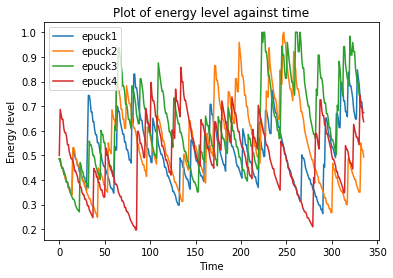

In [12]:
# The line below is mandatory to inform the notebook we want to plot directly in it
%pylab inline
# Plot the energy levels recorded by all epucks
plt.plot(epuck1.get_log("energy"))
plt.plot(epuck2.get_log("energy"))
plt.plot(epuck3.get_log("energy"))
plt.plot(epuck4.get_log("energy"))
plt.legend(["epuck1", "epuck2","epuck3", "epuck4"])
plt.xlabel("Time")
plt.ylabel("Energy level")
plt.title("Plot of energy level against time")
plt.show()

### Plotting the sphere number

Populating the interactive namespace from numpy and matplotlib


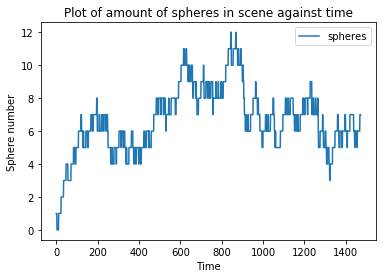

In [13]:
# The line below is mandatory to inform the notebook we want to plot directly in it
%pylab inline
# Plot the number of spheres in the scene
plt.plot(SPHERE_NUMBERS)
plt.legend(["spheres"])
plt.xlabel("Time")
plt.ylabel("Sphere number")
plt.title("Plot of amount of spheres in scene against time")
plt.show()

## Discussion

### Summary of the project
The project aims to simulate the emergence of the tragedy of the commons and a behavioral solution to it. Through our simulation, we can see what the consequences are in the environment when one type or another of behavior occurs, i.e., if occurs the selfish behavior, the altruistic behavior or a combination of both in the population. The results found are:

  * There is a drastic reduction of the shared resource when the entire population exhibits selfish behavior, regardless of the common good. In addition, the energies of the robots (welfare of each individual) are less homogeneous and vary more in range.


  * The amount of resources remains stable if the entire population exhibits altruistic behavior. The robots, in this case, do not act selfish but take into account the energy levels of the other robots ("individuals") allowing them to acquire the resource if their energy is lower. Also, they only eat when there really is a need (when their energy is below a threshold). The common good is being taken into account in this case.
  

  * In reality, we usually find that there is a combination of both behaviors between individuals that are part of a particular ecosystem. In this case, if the environmental conditions are normal, the selfish agents win and the altruistic population is driven to extinction.



### Limitations
Our scene represents only a very simple model: we are working with a small number of "animals", which have very limited capabilities of sensing and manipulating their environment. The behaviors we implemented are only a very rough approximation of real animal behaviors and our simulation might therefore not actually represent the situation well enough to draw any conclusions. The virtual environment we worked with posed a number of problems - sometimes, for example, robots would be knocked prone by a newly appearing energy source. Also, stopping the robots from not getting stuck in corners or against each other did not always work as expected. 



### Possible extensions

In the theory of the Tragedy of the Commons it is important to take into account (1) what are the conditions of the environment and (2) the difficulty of obtaining a new resource when it is being exploited. Therefore, our model can be extended so that (1) robots can have knowledge of environmental conditions, i.e., know if there are more or fewer resources in the ecosystem and (2) control the frequency of the appearance of resources since if the environment is being exploited (overexploitation) the time of appearing a new resource would be more than if the medium is in stable/normal conditions.

Building on our model, it would be possible to create a simulation that is very close to a realistic scenario. This might be done using technologies such as deep-learning in order to model more complex agents and environments.
Such a simulation might then be used in order to gain new insights on topics such as animal or human behavior, the mechanics of reinforcement learning (https://arxiv.org/abs/1707.06600) or even the emergence of social structures and ethics.
   